# Mapping problem using moscot  
from dissociated nPOD scRNAseq data to spatial data  
Dissociated data preprocced by Rebecca Melton from Gaulton's lab 

### Import packages

In [1]:
!pip install decoupler

In [2]:
!pip install -U "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html


In [3]:
import time
import warnings
from tqdm import TqdmWarning
warnings.filterwarnings("ignore", category=TqdmWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
import moscot as mt
#from moscot import datasets
from moscot.problems.space import MappingProblem
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns
import scanpy as sc
import squidpy as sq

### Data sets

In [4]:
adata = sc.read('/lustre/groups/ml01/datasets/projects/20230301_Sander_SpatialPancreas_sara.jimenez/scrna/072424_npod_RNA_raw.h5ad')
adata_s1 = sc.read('../../../../../../datasets/projects/20230301_Sander_SpatialPancreas_sara.jimenez/spatial/S1_annotated_l0.h5ad')

adata, adata_s1

(AnnData object with n_obs × n_vars = 276906 × 36601
     obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.1', 'seurat_clusters', 'samples', 'sex', 'condition', 'RNA_snn_res.0.5', 'celltype_assignment1', 'SeuratClusters', 'celltype_assignment2', 'barcode', 'nPOD_barcode', 'CurrentObjLabels', 'nPOD_ID', 'technology', 'nCount_RAW_mtx', 'nFeature_RAW_mtx', 'conditionSubtype', 'CellTypes'
     var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
     obsm: 'X_harmony', 'X_pca', 'X_umap'
     layers: 'counts',
 AnnData object with n_obs × n_vars = 108711 × 979
     obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_

### Subsetting and pre-processing

In [5]:
adata.obs['nPOD_ID'].cat.categories

Index(['6197', '6220', '6228', '6229', '6234', '6236', '6247', '6264', '6267',
       '6278', '6282', '6310', '6339', '6362', '6366', '6375', '6380', '6393',
       '6401', '6405', '6418', '6424', '6429', '6431', '6450', '6456', '6459',
       '6479', '6505', '6512', '6520', '6521', 'multi_6220', 'multi_6228',
       'multi_6229', 'multi_6234', 'multi_6236', 'multi_6267', 'multi_6362',
       'multi_6375'],
      dtype='object')

In [6]:
adata.obs['condition'].cat.categories

Index(['Aab', 'Control', 'T1D'], dtype='object')

Rebecca's filtering criteria: for each cell type we excluded donors with fewer than 20 cells in that cell type  and then excluded any cell type from analysis if there was not at least 2 non-diabetic and 2 disease condition donors. 

In [7]:
# Step 1: Calculate counts of CellTypes per nPOD_ID
celltype_counts = adata.obs.groupby(['nPOD_ID', 'CellTypes']).size().reset_index(name='counts')
# Step 2: Identify groups with fewer than 20 observations
filtered_counts = celltype_counts[celltype_counts['counts'] >= 20]
# Step 3: Keep only observations from filtered nPOD_ID and CellTypes combinations
valid_combinations = set(zip(filtered_counts['nPOD_ID'], filtered_counts['CellTypes']))
filtered_adata = adata[adata.obs.apply(lambda row: (row['nPOD_ID'], row['CellTypes']) in valid_combinations, axis=1)]
filtered_adata

View of AnnData object with n_obs × n_vars = 275215 × 36601
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.1', 'seurat_clusters', 'samples', 'sex', 'condition', 'RNA_snn_res.0.5', 'celltype_assignment1', 'SeuratClusters', 'celltype_assignment2', 'barcode', 'nPOD_barcode', 'CurrentObjLabels', 'nPOD_ID', 'technology', 'nCount_RAW_mtx', 'nFeature_RAW_mtx', 'conditionSubtype', 'CellTypes'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    layers: 'counts'

In [8]:
# Step 1: Calculate counts of each 'condition' per 'CellTypes'
condition_counts = filtered_adata.obs.groupby(['CellTypes', 'condition']).size().unstack(fill_value=0)

# Step 2: Identify 'CellTypes' that do not meet the specified criteria
# Criteria: 
# - Count of 'Aab' and 'Control' should be at least 2 each
# - Count of 'T1D' should be at least 2

invalid_celltypes = condition_counts[
    (condition_counts['Aab'] < 2) |
    (condition_counts['Control'] < 2) |
    (condition_counts['T1D'] < 2)
].index

# Step 3: Filter the AnnData object to remove invalid 'CellTypes'
adata_sc = filtered_adata[~filtered_adata.obs['CellTypes'].isin(invalid_celltypes)]
adata_sc

View of AnnData object with n_obs × n_vars = 274947 × 36601
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.1', 'seurat_clusters', 'samples', 'sex', 'condition', 'RNA_snn_res.0.5', 'celltype_assignment1', 'SeuratClusters', 'celltype_assignment2', 'barcode', 'nPOD_barcode', 'CurrentObjLabels', 'nPOD_ID', 'technology', 'nCount_RAW_mtx', 'nFeature_RAW_mtx', 'conditionSubtype', 'CellTypes'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    layers: 'counts'

In [9]:
len(adata_sc.obs.CellTypes.cat.categories),len(adata.obs.CellTypes.cat.categories)

(14, 18)

In [10]:
adata_sc.obs.CellTypes.cat.categories

Index(['Acinar_basal', 'Acinar_highEnz', 'Acinar_sigdiff', 'Acinar_signal',
       'Activated_Stellate', 'Alpha', 'Beta', 'Delta', 'Ductal', 'Endothelial',
       'MUC5b_Ductal', 'Macrophage', 'Quiescent_Stellate', 'Tcells'],
      dtype='object')

In [11]:
adata_s1.uns['cell_type_coarse_colors'] = [
    '#edd892', #acinar
    '#219ebc', #alpha
    '#adc178', #beta
    '#f79824', #ductal
    '#718355', #endocrine
    '#f15156', #endothelial
    '#bbd0ff', #Fibroblasts
    '#979dac', #Immune
    '#582f0e'  #mast
]

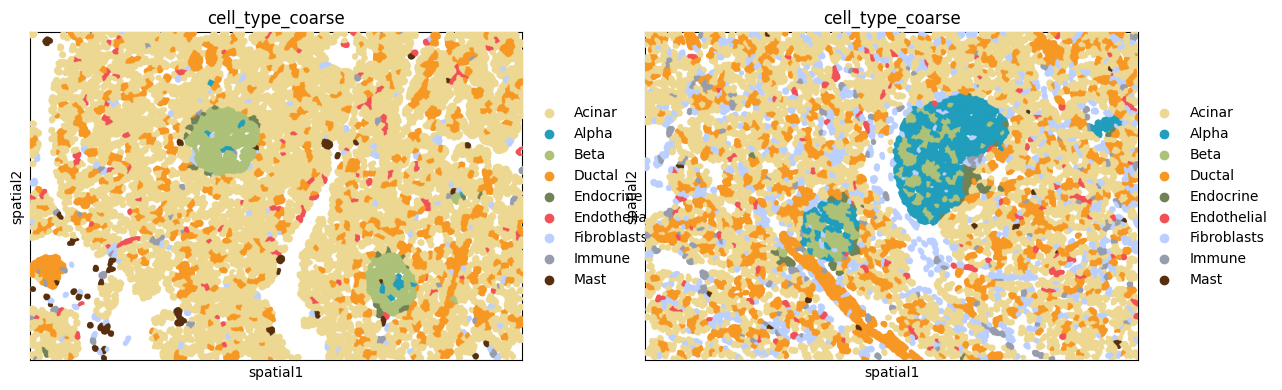

In [12]:
sq.pl.spatial_segment(adata_s1,color='cell_type_coarse',ncols=2,library_id=['10','12'],
                      library_key='fov', seg_cell_id='cell_ID',img=False)

In [13]:
adata_sc.uns['CellTypes_colors'] = [
    '#4FB3AA',#'Acinar_basal'
    '#005F73',#'Acinar_highEnz', 
    '#0A9396',#'Acinar_sigdiff', 
    '#5FD3CF',#'Acinar_signal',
    '#e07a5f',#'Activated_Stellate', 
    '#b5838d',#'Alpha', 
    #'#f8ad9d',#'Bcells', 
    '#ffd6ff',#'Beta', 
    '#c8b6ff',#'Delta', 
    '#bde0fe',#'Ductal',
    '#f2cc8f',#'Endothelial', 
    #'#ffa62b',#'LymphEndo', 
    '#6096ba',#'MUC5b_Ductal', 
    '#8d0801',#'Macrophage', 
    #'#4f000b',#'Mast',
    '#ff7f51',#'Quiescent_Stellate', 
    #'#ce4257',#'Schwann', 
    '#e5383b',#'Tcells'
]

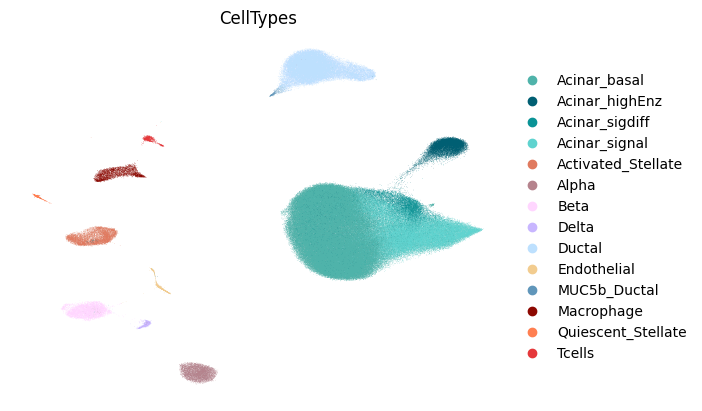

In [14]:
sc.pl.umap(adata_sc, color='CellTypes',frameon=False)

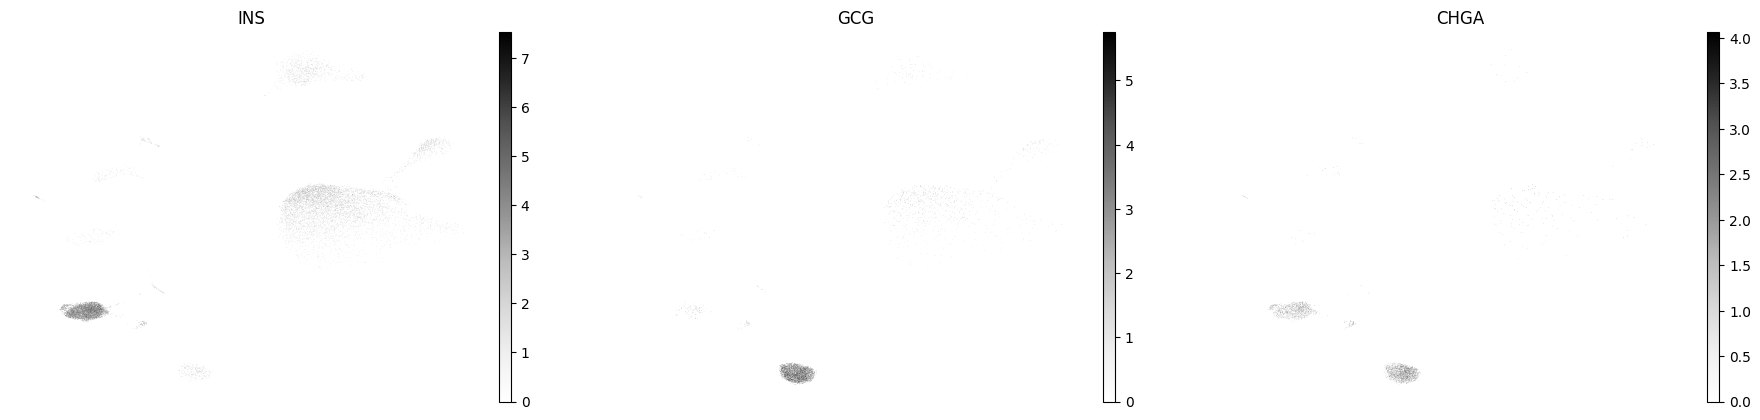

In [15]:
sc.pl.umap(adata_sc, color=['INS','GCG','CHGA'],frameon=False,cmap='Greys')

In [16]:
sc.pp.highly_variable_genes(
    adata_sc,
    n_top_genes=5000,
    subset=True,
    #layer='counts',
    #batch_key='nPOD_ID'#when using sample --> INS isn't kept 
)
adata_sc

AnnData object with n_obs × n_vars = 274947 × 5000
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.1', 'seurat_clusters', 'samples', 'sex', 'condition', 'RNA_snn_res.0.5', 'celltype_assignment1', 'SeuratClusters', 'celltype_assignment2', 'barcode', 'nPOD_barcode', 'CurrentObjLabels', 'nPOD_ID', 'technology', 'nCount_RAW_mtx', 'nFeature_RAW_mtx', 'conditionSubtype', 'CellTypes'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'CellTypes_colors', 'hvg'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    layers: 'counts'

Pseudobulk dissociated data

In [17]:
import decoupler as dc

In [18]:
# Get filtered pseudo-bulk profile
pdata = dc.get_pseudobulk(
    adata_sc,
    sample_col='samples',
    groups_col='CellTypes',
    layer='counts',
    mode='sum',
    min_cells=10,
    min_counts=1000
)
pdata

AnnData object with n_obs × n_vars = 432 × 5000
    obs: 'samples', 'sex', 'condition', 'CurrentObjLabels', 'nPOD_ID', 'technology', 'conditionSubtype', 'CellTypes', 'psbulk_n_cells', 'psbulk_counts'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    layers: 'psbulk_props'

In [19]:
# Store raw counts in layers
pdata.layers['counts'] = pdata.X.copy()

# Normalize, scale and compute pca
sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)
sc.pp.scale(pdata, max_value=10)
sc.tl.pca(pdata)

# Return raw counts to X
#dc.swap_layer(pdata, 'counts', X_layer_key=None, inplace=True)

In [20]:
pdata.uns['CellTypes_colors'] = [
    '#4FB3AA',#'Acinar_basal'
    '#005F73',#'Acinar_highEnz', 
    '#0A9396',#'Acinar_sigdiff', 
    '#5FD3CF',#'Acinar_signal',
    '#e07a5f',#'Activated_Stellate', 
    '#b5838d',#'Alpha', 
    #'#f8ad9d',#'Bcells', 
    '#ffd6ff',#'Beta', 
    '#c8b6ff',#'Delta', 
    '#bde0fe',#'Ductal',
    '#f2cc8f',#'Endothelial', 
    #'#ffa62b',#'LymphEndo', 
    '#6096ba',#'MUC5b_Ductal', 
    '#8d0801',#'Macrophage', 
    #'#4f000b',#'Mast',
    '#ff7f51',#'Quiescent_Stellate', 
    #'#ce4257',#'Schwann', 
    '#e5383b',#'Tcells'
]

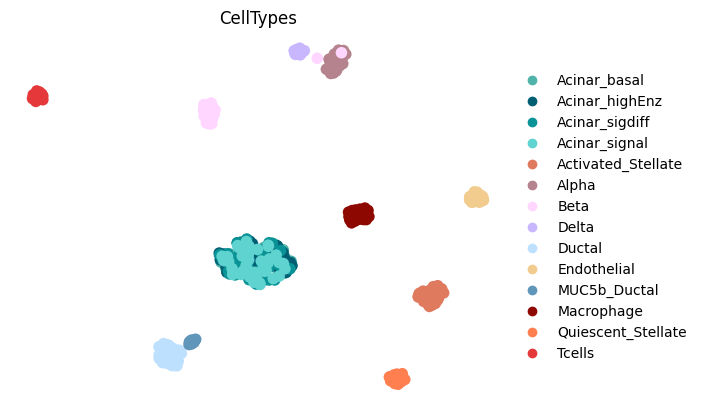

In [21]:
sc.pp.neighbors(pdata)
sc.tl.umap(pdata)
sc.pl.umap(pdata, color='CellTypes', frameon=False)

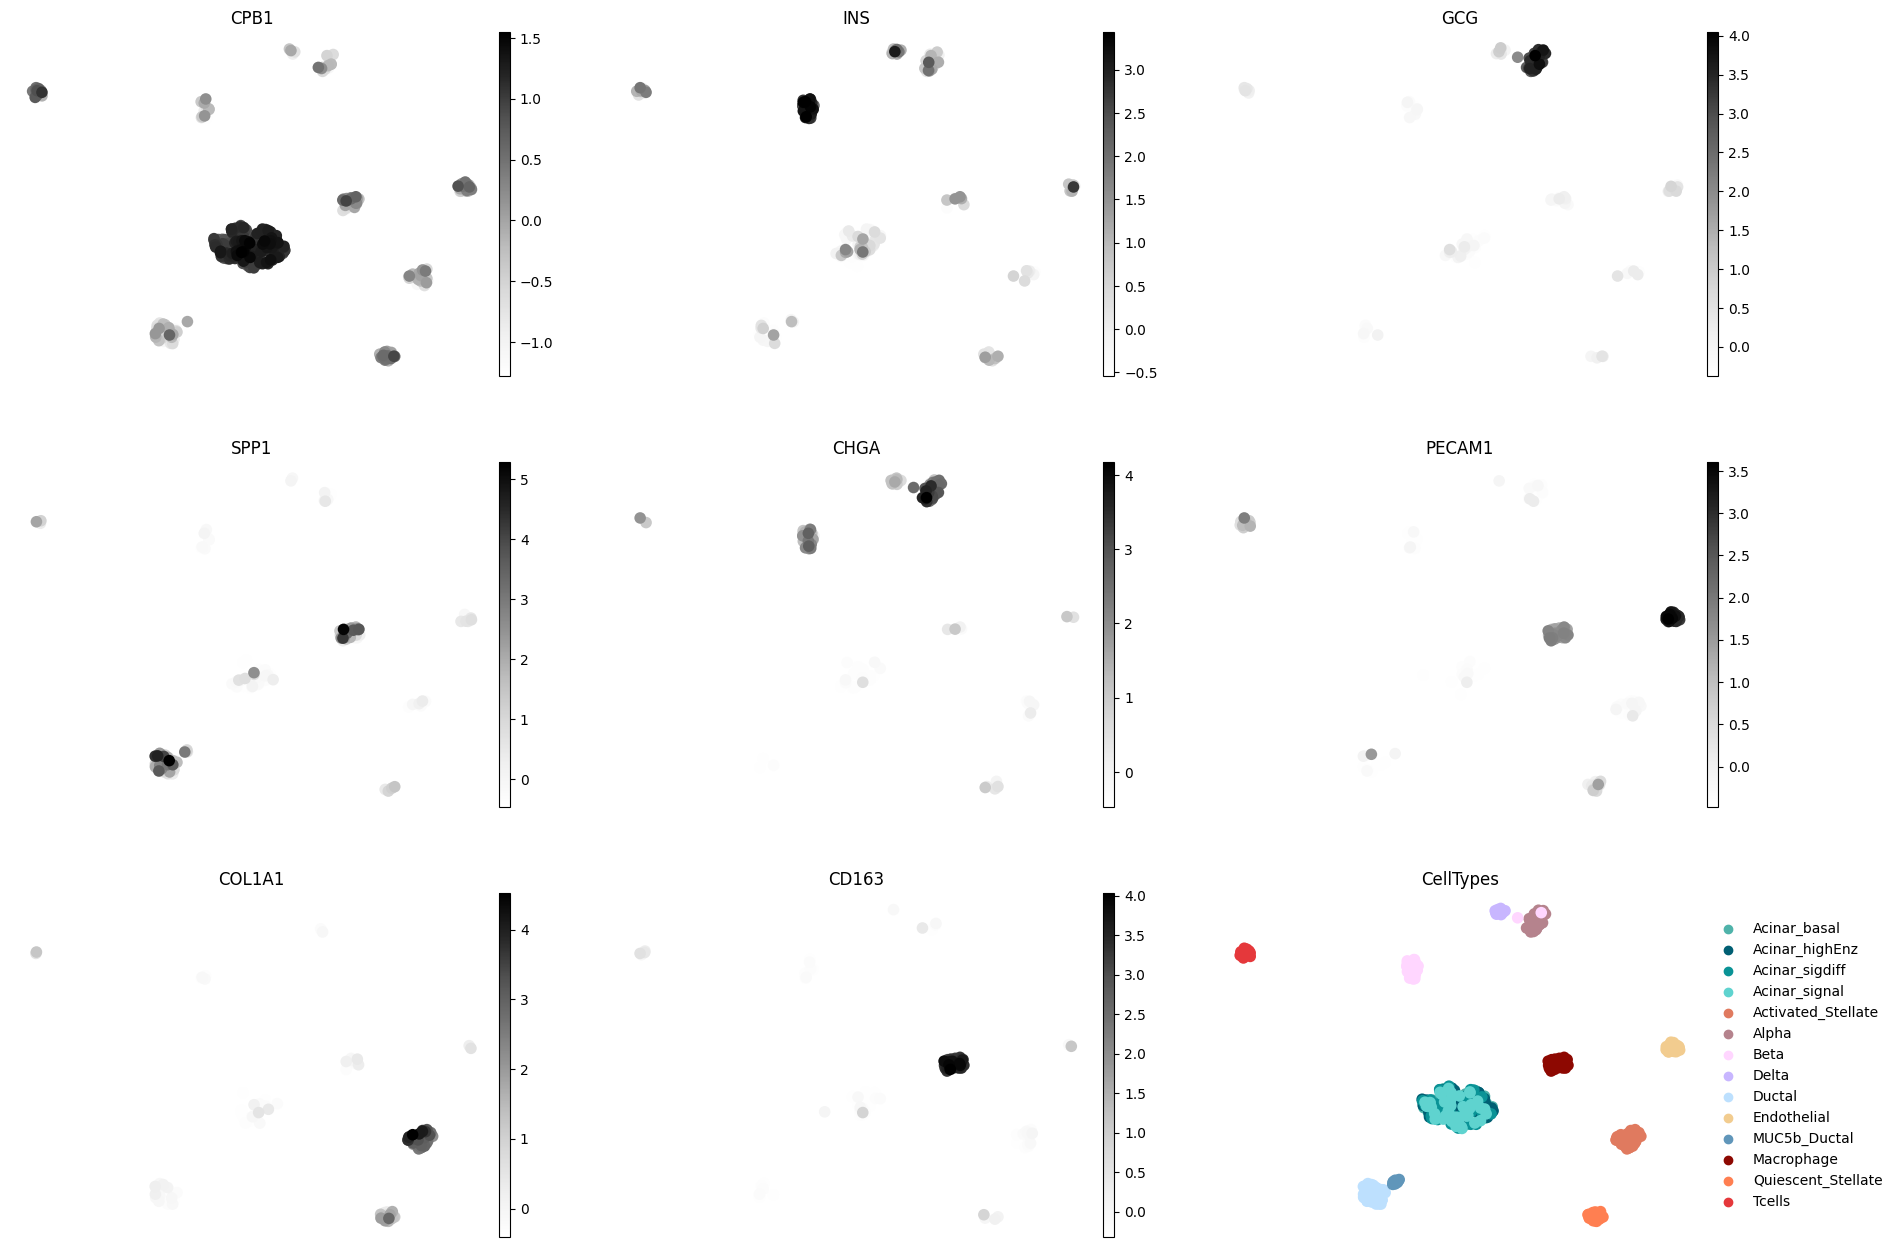

In [22]:
# 'CPB1', 'INS', 'GCG', 'SPP1', 'CHGA', 'PECAM1', 'COL1A1', 'CD163'
sc.pl.umap(pdata,color=['CPB1', 'INS', 'GCG', 'SPP1', 'CHGA', 'PECAM1', 'COL1A1', 'CD163','CellTypes'],
          ncols=3,cmap='Greys',frameon=False)

In [23]:
adata_s1

AnnData object with n_obs × n_vars = 108711 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse'
    var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'spatial', 'cell_type_coarse_colors'
    obsm: 'spatial', 'spatial_fov'
    layers: 'counts'

### Pre-process for each fov

In [24]:
range(len(adata_s1.obs.fov.cat.categories))

range(0, 24)

In [25]:
adatas_pp = []
for i in range(len(adata_s1.obs.fov.cat.categories)):
    fov = str(i+1)
    adata_pp = adata_s1[np.isin(adata_s1.obs['fov'],[fov])].copy()
    sc.pp.pca(adata_pp)
    sc.pp.neighbors(adata_pp)
    sc.tl.umap(adata_pp)
    adatas_pp.append(adata_pp)
    del adata_pp
#adatas_pp    

In [26]:
import anndata as ad
adata_pp  = ad.concat(adatas_pp, join='outer',uns_merge='same',axis=0)
adata_pp

AnnData object with n_obs × n_vars = 108711 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse'
    uns: 'spatial', 'pca', 'neighbors', 'umap'
    obsm: 'spatial', 'spatial_fov', 'X_pca', 'X_umap'
    layers: 'counts'

In [27]:
adata_pp.obs.fov

1_1         1
2_1         1
3_1         1
4_1         1
5_1         1
           ..
4724_24    24
4725_24    24
4726_24    24
4727_24    24
4728_24    24
Name: fov, Length: 108711, dtype: category
Categories (24, object): ['1', '2', '3', '4', ..., '21', '22', '23', '24']

### Preprare and solve the mapping problem 

In [36]:
genes = pd.read_csv('../../../../spatial_pancreas_data/preprocessed_data/genes2impute.txt', delimiter='\t', header=None)
genes2impute = list(genes[(np.isin(genes[0],adata_sc.var_names))][0])
#control_markers = pd.DataFrame(['CPB1','INS','GCG','SPP1','CHGA','PECAM1','COL1A1','CD163'])
control_markers = pd.DataFrame(['CPB1','INS','GCG','SPP1','CHGA'])
markers2impute = list(control_markers[np.isin(control_markers,adata_sc.var_names)][0])
genes2impute = genes2impute + markers2impute

In [37]:
markers2impute

['CPB1', 'INS', 'GCG', 'SPP1', 'CHGA']

In [38]:
# Leave the control genes out of the fitting
adata_pp_mp = adata_pp[:,~adata_pp.var_names.isin(markers2impute)].copy()

In [39]:
params = {
    'epsilon': 0.1,#[0.05, 0.1], #0.01 default 
    'alpha': 0.5,#[0.2,0.3], #0.5 default
    'tau_a': [0.995, 0.990, 0.900],#[1, 0.999, 0.995, 0.990, 0.900], #0.990 default
    'tau_b': [0.900]#[1, 0.999, 0.995, 0.990, 0.900] #0.990 default
}

In [40]:
best_param_fov = []
for i in range(len(adata_pp.obs.fov.cat.categories)):
    fov = str(i+1)
    adata_pp_mp_fov = adata_pp_mp[np.isin(adata_pp_mp.obs['fov'],[fov])].copy()
    adata_pp_fov = adata_pp[np.isin(adata_pp.obs['fov'],[fov])].copy()
    evaluation = []
    for tau_a in params['tau_a']:
        for tau_b in params['tau_b']:
                    
            #prepare mapping problem
            mp = MappingProblem(adata_sc=pdata, adata_sp=adata_pp_mp_fov)
            mp = mp.prepare(
                sc_attr = {'attr': 'obsm', 'key': 'X_pca'}, 
                callback="local-pca" if adata_pp_mp_fov.shape[1] > 100 else None,
                kwargs = {'callback_kwargs': 'local_pca','joint-space': True},
                spatial_key = {'attr': 'obsm', 'key': 'X_pca'},
                cost = 'cosine',#'cosine', #'sq_euclidean', 
                joint_attr = {'attr':'X'}, #'X_pca' {'attr':'X_pca'}
            )
            #solve mapping problem 
            mp = mp.solve(alpha=params['alpha'],epsilon=params['epsilon'],tau_a=tau_a,tau_b=tau_b)
                    
            #evaluating the mapping problem through imputation
            adata_imputed = mp.impute(var_names=genes2impute)
            correlations_hallmark_genes = []
    
            for i in markers2impute:
                gene = i
                obs_genes = adata_pp_fov[:,[gene]].X.copy().toarray().flatten()
                imp_genes = adata_imputed[:,[gene]].X.copy().flatten()
                correlation, p_value = pearsonr(obs_genes, imp_genes)
                row_data = {
                    'gene' : gene,
                    'Pearson_correlation' : correlation,
                    'P_value' : p_value
                }
                correlations_hallmark_genes.append(row_data)
                    
            df = pd.DataFrame(correlations_hallmark_genes)
            #'CPB1', 'INS', 'GCG', 'SPP1', 'CHGA', 'PECAM1', 'COL1A1', 'CD163'
            #print('-----------------------------------------------------------') 
            row_data = {
                'fov' : fov,
                'tau_a' : tau_a,
                'tau_b' : tau_b,
                'cpb1_corr' : df.loc[df['gene'] == 'CPB1', 'Pearson_correlation'].values[0],
                'ins_corr' : df.loc[df['gene'] == 'INS', 'Pearson_correlation'].values[0],
                'gcg_corr' : df.loc[df['gene'] == 'GCG', 'Pearson_correlation'].values[0],
                'spp1_corr' : df.loc[df['gene'] == 'SPP1', 'Pearson_correlation'].values[0],
                'chga_corr' : df.loc[df['gene'] == 'CHGA', 'Pearson_correlation'].values[0],
                #'pecam1_corr' : df.loc[df['gene'] == 'PECAM1', 'Pearson_correlation'].values[0],
                #'col1a1_corr' : df.loc[df['gene'] == 'COL1A1', 'Pearson_correlation'].values[0],
                #'cd163_corr' : df.loc[df['gene'] == 'CD163', 'Pearson_correlation'].values[0],
                'mean_corr' : df['Pearson_correlation'].mean()
            }
            evaluation.append(row_data)
            del mp
            del adata_imputed
    df_fov = pd.DataFrame(evaluation)
    # Find the index label corresponding to the maximum value in a specific column
    max_index_fov = df_fov['mean_corr'].idxmax()
    
    # Retrieve the values of the row with the maximum value in the column
    max_row_values_fov = df_fov.loc[max_index_fov]
    
    best_param_fov_dict = max_row_values_fov.to_dict()
    best_param_fov.append(best_param_fov_dict)
df = pd.DataFrame(best_param_fov)

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4499, 432)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4499, 432)].                                           
INFO     Normalizing spatial coordinates of `x`.                        

In [41]:
df

,fov,tau_a,tau_b,cpb1_corr,ins_corr,gcg_corr,spp1_corr,chga_corr,mean_corr
0,1,0.990,0.9,0.845523,0.876280,0.930061,0.230242,0.886249,0.753671
1,2,0.990,0.9,0.763765,0.813296,0.912142,0.359491,0.877588,0.745256
2,3,0.995,0.9,0.811975,0.847030,0.839919,0.263823,0.807112,0.713972
3,4,0.990,0.9,0.807175,0.860465,0.913806,0.377799,0.906253,0.773099
4,5,0.900,0.9,0.681902,0.038283,0.181509,0.447589,0.082529,0.286362
5,6,0.995,0.9,0.624670,0.474124,0.675426,0.431704,0.571950,0.555575
6,7,0.995,0.9,0.737652,0.810672,0.883710,0.327398,0.865515,0.724990
7,8,0.990,0.9,0.663267,0.672541,0.338719,0.307694,0.569947,0.510434
8,9,0.990,0.9,0.689728,0.720768,0.708877,0.326093,0.731561,0.635405
9,10,0.995,0.9,0.733130,0.763113,0.838477,0.287934,0.779429,0.680417


### Analysis of the transport plan with the best set of found parameters

In [45]:
best_param = {
    'alpha' : 0.5,
    'epsilon' : 0.1,
    'tau_a' : 0.995,
    'tau_b' : 0.9
}

In [42]:
adata_pp

AnnData object with n_obs × n_vars = 108711 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse'
    uns: 'spatial', 'pca', 'neighbors', 'umap'
    obsm: 'spatial', 'spatial_fov', 'X_pca', 'X_umap'
    layers: 'counts'

In [43]:
mp = MappingProblem(adata_sc=pdata, adata_sp=adata_pp)
mp = mp.prepare(
    sc_attr = {'attr': 'obsm', 'key': 'X_pca'}, 
    callback="local-pca" if adata_pp.shape[1] > 100 else None,
    kwargs = {'callback_kwargs': 'local_pca', 'joint-space': True},
    spatial_key = {'attr': 'obsm', 'key': 'X_pca'},
    cost = 'cosine', #'sq_euclidean', 
    joint_attr = {"attr":"X"}, #'X_pca' {'attr':'X_pca'}
    batch_key = 'fov'
)

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Normalizing spatial coordinates of `x`.                        

In [44]:
mp

MappingProblem[('15', 'ref'), ('22', 'ref'), ('5', 'ref'), ('21', 'ref'), ('6', 'ref'), ('14', 'ref'), ('19', 'ref'), ('23', 'ref'), ('1', 'ref'), ('8', 'ref'), ('12', 'ref'), ('18', 'ref'), ('2', 'ref'), ('9', 'ref'), ('17', 'ref'), ('7', 'ref'), ('24', 'ref'), ('3', 'ref'), ('13', 'ref'), ('20', 'ref'), ('11', 'ref'), ('10', 'ref'), ('4', 'ref'), ('16', 'ref')]

In [46]:
#solve mapping problem 
mp = mp.solve(alpha=best_param['alpha'],epsilon=best_param['epsilon'],tau_a=best_param['tau_a'],tau_b=best_param['tau_b'])


INFO     Solving `24` problems                                                                                     
INFO     Solving problem OTProblem[stage='prepared', shape=(5401, 432)].                                           
INFO     Solving problem OTProblem[stage='prepared', shape=(4810, 432)].                                           
INFO     Solving problem OTProblem[stage='prepared', shape=(3895, 432)].                                           
INFO     Solving problem OTProblem[stage='prepared', shape=(4053, 432)].                                           
INFO     Solving problem OTProblem[stage='prepared', shape=(4206, 432)].                                           
INFO     Solving problem OTProblem[stage='prepared', shape=(2321, 432)].                                           
INFO     Solving problem OTProblem[stage='prepared', shape=(4342, 432)].                                           
INFO     Solving problem OTProblem[stage='prepared', shape=(5583, 432)].

#### Imputation

In [ ]:
# impute the 5k HVG from sc data 

start_time = time.time()

adatas_imputed = []
for i in range(int(len(pdata.var_names)/20)):
    adata_imputed = mp.impute(var_names=pdata.var_names[i*20:i*20+20],device='cuda:0')
    adatas_imputed.append(adata_imputed)
    del adata_imputed

end_time = time.time()
execution_time = end_time - start_time

print("Execution time:", execution_time, "seconds")

In [ ]:
adata_imputed  = ad.concat(adatas_imputed, join='outer',uns_merge='same',axis=1)
adata_imputed 

In [ ]:
adata_imputed.uns['spatial'] = adata_pp.uns['spatial']
adata_imputed.obsm['spatial'] = adata_pp.obsm['spatial']
adata_imputed.obs['fov'] = adata_pp.obs['fov']
adata_imputed.obs['cell_ID'] = adata_pp.obs['cell_ID']  

adata_imputed

Plotting imputed gene expression

In [ ]:
markers2impute

In [ ]:
sq.pl.spatial_segment(adata_imputed,color=markers2impute,ncols=3,library_id='12',
                      library_key='fov', seg_cell_id='cell_ID',cmap='Greys', img=False)

#### Annotation mapping

In [47]:
mp

MappingProblem[('15', 'ref'), ('22', 'ref'), ('5', 'ref'), ('21', 'ref'), ('6', 'ref'), ('14', 'ref'), ('19', 'ref'), ('23', 'ref'), ('1', 'ref'), ('8', 'ref'), ('12', 'ref'), ('18', 'ref'), ('2', 'ref'), ('9', 'ref'), ('17', 'ref'), ('7', 'ref'), ('24', 'ref'), ('3', 'ref'), ('13', 'ref'), ('20', 'ref'), ('11', 'ref'), ('10', 'ref'), ('4', 'ref'), ('16', 'ref')]

In [48]:
type(pdata.obs.CellTypes)

pandas.core.series.Series

In [49]:
pdata.obs.cell_type = pdata.obs.CellTypes.astype("category")

Annotation mapping using “max” mode

In [50]:
start_time = time.time()

anno_map_max = mp.annotation_mapping(
    "max",
    annotation_label="CellTypes",
    source="1",
    target="ref",
    forward=False,
    batch_size=256,
)

adata_pp.obs["CellTypes_max"] = anno_map_max["CellTypes"].values
adata_pp.obs["CellTypes_max"] = adata_pp.obs["CellTypes_max"].astype("category")

end_time = time.time()
execution_time = end_time - start_time

print("Execution time:", execution_time, "seconds")

KeyError: 'fov'

In [1]:
best_param = {
    'alpha' : 0.5,
    'epsilon' : 0.1,
    'tau_a' : 0.99, #changed it 
    'tau_b' : 0.9
}

In [ ]:
adatas_ann = []
for i in range(len(adata_pp.obs.fov.cat.categories)):
    fov = str(i+1)
    adata_pp_fov = adata_pp[np.isin(adata_pp.obs['fov'],[fov])].copy()
    mp = MappingProblem(adata_sc=pdata, adata_sp=adata_pp_fov)
    mp = mp.prepare(
        sc_attr = {'attr': 'obsm', 'key': 'X_pca'}, 
        callback="local-pca" if adata_pp.shape[1] > 100 else None,
        kwargs = {'callback_kwargs': 'local_pca', 'joint-space': True},
        spatial_key = {'attr': 'obsm', 'key': 'X_pca'},
        cost = 'cosine', #'sq_euclidean', 
        joint_attr = {"attr":"X"}, #'X_pca' {'attr':'X_pca'}
    )
    #solve mapping problem 
    mp = mp.solve(alpha=best_param['alpha'],epsilon=best_param['epsilon'],tau_a=best_param['tau_a'],tau_b=best_param['tau_b'])
    #annotation mapping
    anno_map_max = mp.annotation_mapping(
        "max",
        "CellTypes",
        source="src",
        #target="1",
        forward=False,
        batch_size=256,
    )   
    adata_pp_fov.obs["CellTypes_max"] = anno_map_max["CellTypes"].values
    adata_pp_fov.obs["CellTypes_max"] = adata_pp_fov.obs["CellTypes_max"].astype("category")
    
    adatas_ann.append(adata_pp_fov)
    del adata_pp_fov
    del mp

In [ ]:
adata_ann  = ad.concat(adatas_ann, join='outer',uns_merge='same',axis=0)
adata_imputed 

In [ ]:
#sc.pl.umap(adata_sc, color="cell_type")
sc.pl.umap(adata_10, color=["CellTypes_max"], frameon=False)
sc.pl.umap(adata_12, color=["CellTypes_max"], frameon=False)

In [ ]:
adata_10.uns['CellTypes_max_colors'] = [
    '#4FB3AA',#'Acinar_basal'
    '#005F73',#'Acinar_highEnz', 
    '#0A9396',#'Acinar_sigdiff', 
    '#5FD3CF',#'Acinar_signal',
    '#e07a5f',#'Activated_Stellate', 
    '#b5838d',#'Alpha', 
    #'#f8ad9d',#'Bcells', 
    '#ffd6ff',#'Beta', 
    '#c8b6ff',#'Delta', 
    '#bde0fe',#'Ductal',
    '#f2cc8f',#'Endothelial', 
    '#ffa62b',#'LymphEndo', 
    '#6096ba',#'MUC5b_Ductal', 
    '#8d0801',#'Macrophage', 
    '#4f000b',#'Mast',
    '#ff7f51',#'Quiescent_Stellate', 
    #'#ce4257',#'Schwann', 
    '#e5383b',#'Tcells'
]

adata_12.uns['CellTypes_max_colors'] = [
    '#4FB3AA',#'Acinar_basal'
    '#005F73',#'Acinar_highEnz', 
    '#0A9396',#'Acinar_sigdiff', 
    '#5FD3CF',#'Acinar_signal',
    '#e07a5f',#'Activated_Stellate', 
    '#b5838d',#'Alpha', 
    #'#f8ad9d',#'Bcells', 
    '#ffd6ff',#'Beta', 
    '#c8b6ff',#'Delta', 
    '#bde0fe',#'Ductal',
    '#f2cc8f',#'Endothelial', 
    '#ffa62b',#'LymphEndo', 
    '#6096ba',#'MUC5b_Ductal', 
    '#8d0801',#'Macrophage', 
    '#4f000b',#'Mast',
    '#ff7f51',#'Quiescent_Stellate', 
    #'#ce4257',#'Schwann', 
    '#e5383b',#'Tcells'
]

In [ ]:
sq.pl.spatial_segment(adata_10,color='CellTypes_max',size=5,library_key='fov', seg_cell_id='cell_ID', img=False)

sq.pl.spatial_segment(adata_12,color='CellTypes_max',size=5,library_key='fov', seg_cell_id='cell_ID', img=False)

In [ ]:
sq.pl.spatial_segment(adata_10,color=['cell_type_coarse','CellTypes_max'],size=5,ncols=2,library_key='fov', seg_cell_id='cell_ID',img=False)
sq.pl.spatial_segment(adata_12,color=['cell_type_coarse','CellTypes_max'],size=5,ncols=2,library_key='fov', seg_cell_id='cell_ID',img=False)

In [ ]:
adata_10, adata_12

In [ ]:
folder = '/lustre/groups/ml01/workspace/sara.jimenez/spatial_pancreas_data/preprocessed_data/data4downstream/'

adata_10.write(folder+'adata_fov_10_npod_annotation_wo_B+Schwann.h5ad')
adata_12.write(folder+'adata_fov_12_npod_annotation_wo_B+Schwann.h5ad')

In [ ]:
sc.pl.embedding(adata_10,color=['CellTypes_max'],groups=['Beta','Mast'],basis='spatial')
sc.pl.embedding(adata_12,color=['CellTypes_max'],groups=['Beta','Mast'],basis='spatial')

In [ ]:
sq.gr.spatial_neighbors(
    adata_sp_fov_12,
    n_neighs=15,
    coord_type="generic",
    delaunay=True,
)

In [ ]:
_, idx = adata_sp_fov_12.obsp["spatial_connectivities"][420, :].nonzero()
idx = np.append(idx, 420)
sq.pl.spatial_scatter(
    adata_sp_fov_12[idx,420],
    library_id = '12',
    color="Cluster_max",
    connectivity_key="spatial_connectivities",
    size=3,
    edges_width=1,
    edges_color="black",
    img=False,
    title="K-nearest neighbors"
)

In [ ]:
sq.gr.nhood_enrichment(adata_sp_fov_12,cluster_key='Cluster_max')

In [ ]:
sq.pl.nhood_enrichment(adata_sp_fov_12, cluster_key='Cluster_max',cmap='Greys')

In [ ]:
sq.gr.interaction_matrix(adata_sp_fov_12, cluster_key='Cluster_max',weights=True)

In [ ]:
sq.pl.interaction_matrix(adata_sp_fov_12, cluster_key='Cluster_max',cmap='Greys')